# SAM 3D Body Demo
#Copyright (c) Meta Platforms, Inc. and affiliates.

This notebook demonstrates how to use the SAM 3D Body model for inference.

## 1. Imports and Model Loading

In [8]:
import sys
import os

parent_dir = os.path.dirname(os.getcwd()) 
sys.path.insert(0, parent_dir)

from utils import (
    setup_visualizer, visualize_2d_results, visualize_3d_mesh, save_mesh_results, display_results_grid,
    process_image_with_mask
)
from sam_3d_body import build_sam_3d_body_hf

moge_path = "Ruicheng/moge-2-vitl-normal"
detector_path = "/large_experiments/3po/model/cascade_mask_rcnn_vitdet"
model = build_sam_3d_body_hf("facebook/sam-3d-body-vith", moge_path=moge_path, detector_path=detector_path)

# Set up visualizer
visualizer = setup_visualizer()

print("Setup complete!")

Fetching 15 files: 100%|██████████| 15/15 [00:00<00:00, 2510.36it/s]


Loading ATLAS from /private/home/jiawliu/.cache/huggingface/hub/models--facebook--sam-3d-body-vith/snapshots/55950e1003d1aa115e25ee992a0b81c922d0ea82/assets ...
Done loading pkl!
ATLAS is using 45 shape components (20 body, 20 face, 5 hand), 28 scale components (18 body, 10 hand), 54 pose PCA components per hand.
Loading Pose Correctives...
Loading Hand Prior...


The model and loaded state dict do not match exactly

missing keys in source state_dict: head_pose.atlas.shape_mean, head_pose.atlas.shape_comps, head_pose.atlas.scale_mean, head_pose.atlas.scale_comps, head_pose.atlas.faces, head_pose.atlas.hand_pose_mean, head_pose.atlas.hand_pose_comps, head_pose.atlas.exprdirs, head_pose.atlas.keypoint_mapping, head_pose.atlas.model_param_limits, head_pose.atlas.flexible_model_params_mask, head_pose.atlas.hand_pose_comps_ori, head_pose.atlas.posedirs.0.sparse_indices, head_pose.atlas.posedirs.0.sparse_weight, head_pose.atlas.posedirs.2.weight, head_pose.atlas.lbs_fn_infos.joint_depths, head_pose.atlas.lbs_fn_infos.joint_offset, head_pose.atlas.lbs_fn_infos.joint_parents, head_pose.atlas.lbs_fn_infos.joint_rotation, head_pose.atlas.lbs_fn_infos.model_param_limits, head_pose.atlas.lbs_fn_infos.param_transform



Setup complete!


## 2. Process Image and Get Outputs

Processing image with SAM 3D Body...
Running object detector...
Number of people detected: 1
Output keys for first person: ['bbox', 'focal_length', 'pred_keypoints_3d', 'pred_vertices', 'pred_cam_t', 'pred_keypoints_2d', 'pred_pose_raw', 'global_rot', 'body_pose_params', 'hand_pose_params', 'scale_params', 'shape_params', 'expr_params', 'mask', 'pred_joint_coords', 'lhand_bbox', 'rhand_bbox']


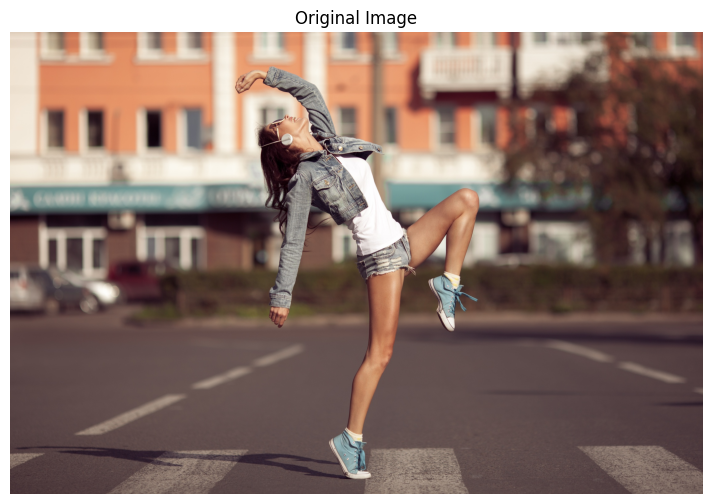

In [9]:
import cv2
import matplotlib.pyplot as plt

# Load and process the image
image_path = "images/dancing.jpg"  # Relative to notebook folder
img_cv2 = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)

# Process the image with SAM 3D Body
print("Processing image with SAM 3D Body...")
outputs = model.process_one_image(image_path)

print(f"Number of people detected: {len(outputs)}")
print(f"Output keys for first person: {list(outputs[0].keys()) if outputs else 'No people detected'}")

# Display the original image
plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.axis('off')
plt.title('Original Image')
plt.show()

## 3. 2D Visualization - Keypoints and Bounding Boxes

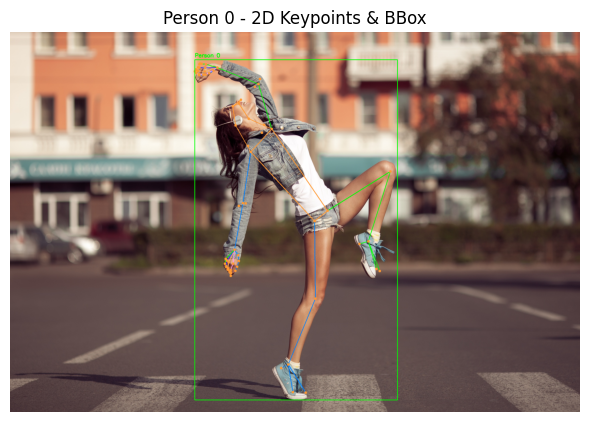

In [10]:
# Visualize 2D results using utils
if outputs:
    vis_results = visualize_2d_results(img_cv2, outputs, visualizer)
    
    # Display results using grid function
    titles = [f'Person {i} - 2D Keypoints & BBox' for i in range(len(vis_results))]
    display_results_grid(vis_results, titles, figsize_per_image=(6, 6))
else:
    print("No people detected in the image")

## 4. 3D Mesh Visualization - Overlay and Side View

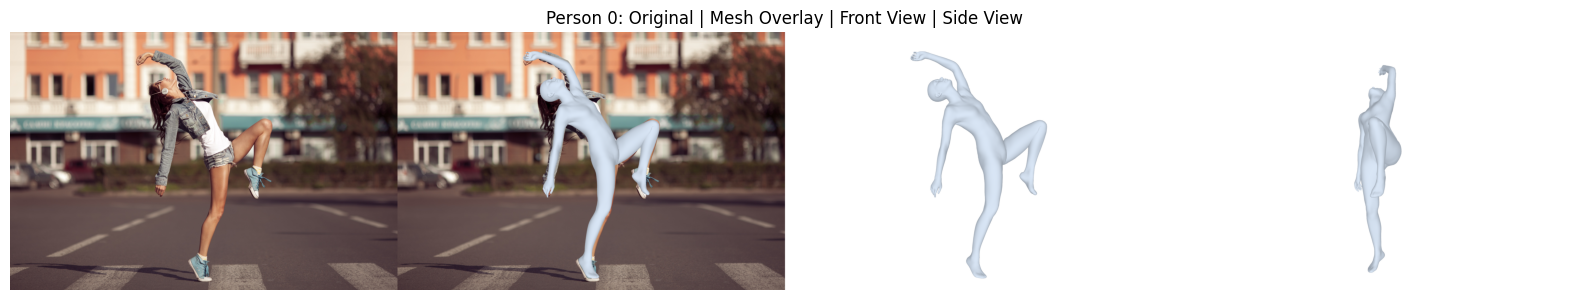

In [11]:
if outputs:
    mesh_results = visualize_3d_mesh(img_cv2, outputs, model.faces)
    
    # Display results
    for i, combined_img in enumerate(mesh_results):
        combined_rgb = cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB)
        
        plt.figure(figsize=(20, 5))
        plt.imshow(combined_rgb)
        plt.title(f'Person {i}: Original | Mesh Overlay | Front View | Side View')
        plt.axis('off')
        plt.show()
else:
    print("No people detected for 3D mesh visualization")

## 5. Save 3D Mesh Files and Results

In [12]:
if outputs:
    # Get image name without extension
    image_name = os.path.splitext(os.path.basename(image_path))[0]
    
    # Create output directory
    output_dir = f"output/{image_name}"
    
    # Save all results (PLY meshes, overlay images, bbox images)
    ply_files = save_mesh_results(img_cv2, outputs, model.faces, output_dir, image_name)
    
    print(f"\n=== Saved Results for {image_name} ===")
    print(f"Output directory: {output_dir}")
    print(f"Number of PLY files created: {len(ply_files)}")
    
    # Display saved file structure
    if os.path.exists(output_dir):
        print(f"\nFiles in {output_dir}:")
        for file in sorted(os.listdir(output_dir)):
            file_path = os.path.join(output_dir, file)
            file_size = os.path.getsize(file_path) / 1024  # KB
            print(f"  {file} ({file_size:.1f} KB)")
else:
    print("No results to save - no people detected")

Saved mesh: output/dancing/dancing_mesh_000.ply
Saved overlay: output/dancing/dancing_overlay_000.png
Saved bbox: output/dancing/dancing_bbox_000.png

=== Saved Results for dancing ===
Output directory: output/dancing
Number of PLY files created: 1

Files in output/dancing:
  dancing_bbox_000.png (3500.2 KB)
  dancing_mesh_000.ply (756.5 KB)
  dancing_overlay_000.png (3184.7 KB)


## 6. Mask-Based Inference

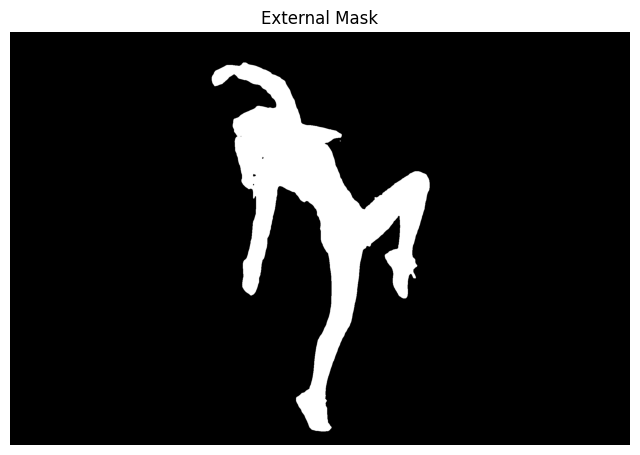

Processing with external mask...
Processing image with external mask: images/dancing_mask.png
Mask shape: (1500, 2250), unique values: [  0 255]
Running object detector...
Using provided masks: (1500, 2250)
Standard detection: 1 people
Mask-based detection: 1 people


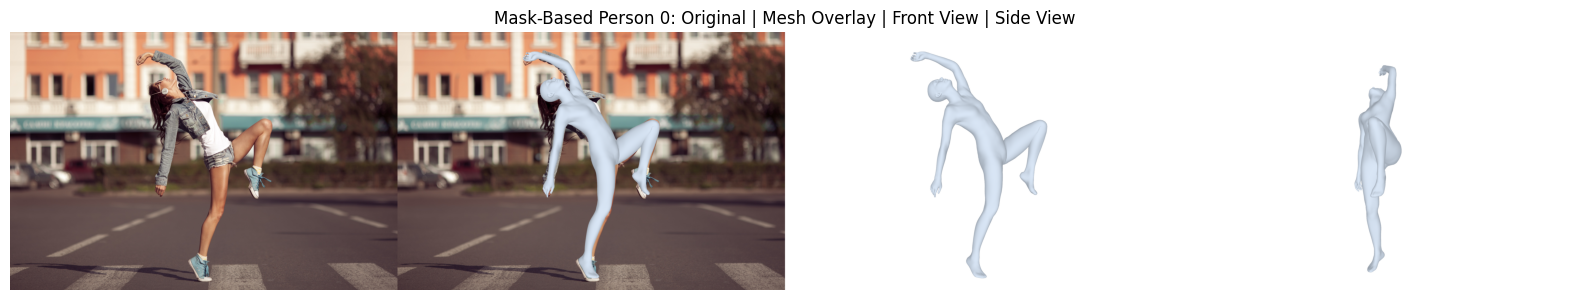

Saved mesh: output/mask_based_dancing/mask_dancing_mesh_000.ply
Saved overlay: output/mask_based_dancing/mask_dancing_overlay_000.png
Saved bbox: output/mask_based_dancing/mask_dancing_bbox_000.png
Saved mask-based results to: output/mask_based_dancing


In [13]:
# Load mask and run inference
mask_path = "images/dancing_mask.png"

if os.path.exists(mask_path):
    # Load and display the mask
    mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(mask_img, cmap='gray')
    plt.title('External Mask')
    plt.axis('off')
    plt.show()
    
    # Process with external mask
    print("Processing with external mask...")
    mask_outputs = process_image_with_mask(model, image_path, mask_path)
    
    print(f"Standard detection: {len(outputs)} people")
    print(f"Mask-based detection: {len(mask_outputs)} people")
    
    # Visualize and save results
    if mask_outputs:
        mask_mesh_results = visualize_3d_mesh(img_cv2, mask_outputs, model.faces)
        
        for i, combined_img in enumerate(mask_mesh_results):
            combined_rgb = cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB)
            
            plt.figure(figsize=(20, 5))
            plt.imshow(combined_rgb)
            plt.title(f'Mask-Based Person {i}: Original | Mesh Overlay | Front View | Side View')
            plt.axis('off')
            plt.show()
            
        # Save results
        mask_output_dir = f"output/mask_based_{image_name}"
        mask_ply_files = save_mesh_results(img_cv2, mask_outputs, model.faces, mask_output_dir, f"mask_{image_name}")
        print(f"Saved mask-based results to: {mask_output_dir}")
    else:
        print("No people detected with mask-based approach")
        
else:
    print(f"Mask file not found: {mask_path}")